# Initial Setup 

In [151]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from bdi_predict.ml_logic.sequence_gen import WindowGenerator
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

In [152]:
df = pd.read_csv("../raw_data/data/BDI/log_diff_BDI_daily.csv")
df.head(2)

,Unnamed: 0,Date,Price,abs_price,log_price,log_diff
0,0,1995-01-03,1964.0,NaN,3.293141,NaN
1,1,1995-01-04,1961.0,-3.0,3.292478,-0.000664


In [153]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df = df[df.index != "1995-01-03"]
df.drop(columns="Unnamed: 0", inplace=True)
df.head(2)

,Price,abs_price,log_price,log_diff
Date,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664
1995-01-05,1967.0,6.0,3.293804,0.001327


REMINDER: New target is: $$log(𝑦𝑡)−log(𝑦𝑡−1)=log(𝑦𝑡/𝑦𝑡−1)$$

# Using our bespoke window/sequence generator to generate sequences:

1. Generate sequences that predict the log difference a day ahead with input length of 10 days (two weeks) 
2. generate sequences that predict the log differences a day ahead with input length of 20 days (a month)

In [154]:
input_length = len(df)

In [155]:
def train_test_split(df:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple:
    '''
    Returns a train dataframe and a test dataframe (df_train, df_test)
    from which one can sample (X,y) sequences using TimeseriesGenerator.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    
    # TRAIN SET

    last_train_idx = round(train_test_ratio * len(df))
    df_train = df.iloc[0:last_train_idx, :]

    # TEST SET
 
    first_test_idx = last_train_idx - input_length
    df_test = df.iloc[first_test_idx:, :]

    return (df_train, df_test)

In [156]:
df_train, df_test = train_test_split(df=df, train_test_ratio=0.8, input_length=input_length)

In [157]:
X_train = df_train[["Price"]]
y_train = df_train["log_diff"]

X_test  = df_test[["Price"]]
y_test = df_test["log_diff"]

In [233]:
#Feature Scaling

scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.fit_transform(X_test)



In [159]:
X_test_scaled.shape

(1413, 1)

In [160]:
y_train[:2]

Date
1995-01-04   -0.000664
1995-01-05    0.001327
Name: log_diff, dtype: float64

In [161]:
generator = TimeseriesGenerator(X_train_scaled, y_train, length=10, batch_size=4, sampling_rate=1, stride=1)

In [162]:
generator_val = TimeseriesGenerator(X_test_scaled, y_test, length=10, batch_size=4, sampling_rate=1, stride=1)

In [164]:
for X, y in generator:
    print(X.shape, y.shape)
    print(X[0], y[0])
    #listy = [float(X[0][i]) for i in range(len(X[0]))]
    #print(listy)
    break

(4, 10, 1) (4,)
[[0.14519214]
 [0.14571379]
 [0.14710485]
 [0.14806121]
 [0.14988698]
 [0.15023474]
 [0.15188663]
 [0.15379934]
 [0.15440793]
 [0.15475569]] 0.0


# Using TimseriesGenerator to create sequences:

# The Model

In [165]:
# Learning Rate Scheduler: 

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

In [166]:
#Optimizers

rmsprop = RMSprop(learning_rate=lr_schedule) #or 0.001 for inital test
adam = Adam(learning_rate=lr_schedule)

In [167]:
#Early Stopping Criterion:

es = EarlyStopping(monitor="val_mae", patience=100, restore_best_weights=True)

In [168]:
#Initializing and compiling model:

def init_model():
    
    model = Sequential()

    #LSTM layers
    model.add(layers.LSTM(60, activation="tanh", input_shape=(10,1), return_sequences=False))

    #Dense layers
    model.add(layers.Dense(150, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    #compiling model
    model.compile(loss="mse", optimizer=rmsprop, metrics="mae")
    
    return model

# Training and Testing

In [35]:
#Instantiating model

model = init_model()

#TRAINING THE MODEL:

history = model.fit(
    generator, epochs=1000, validation_data=generator_val, shuffle=False, callbacks=es
)

Epoch 1/1000
1411/1411 [==============================] - 5s 3ms/step - loss: 5.1822e-05 - mae: 0.0048 - val_loss: 0.0052 - val_mae: 0.0587
Epoch 2/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 5.0053e-05 - mae: 0.0046 - val_loss: 0.0067 - val_mae: 0.0665
Epoch 3/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 4.9261e-05 - mae: 0.0046 - val_loss: 0.0076 - val_mae: 0.0700
Epoch 4/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 5.1051e-05 - mae: 0.0046 - val_loss: 0.0070 - val_mae: 0.0671
Epoch 5/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 5.1741e-05 - mae: 0.0046 - val_loss: 0.0075 - val_mae: 0.0693
Epoch 6/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 4.9415e-05 - mae: 0.0045 - val_loss: 0.0043 - val_mae: 0.0530
Epoch 7/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 4.9632e-05 - mae: 0.0045 - val_loss: 0.0088 - val_mae: 0.0752
Epoch 8/1000
1411/14

1411/1411 [==============================] - 3s 2ms/step - loss: 2.4633e-05 - mae: 0.0031 - val_loss: 9.9409e-04 - val_mae: 0.0292
Epoch 118/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.4598e-05 - mae: 0.0031 - val_loss: 9.6242e-04 - val_mae: 0.0287
Epoch 119/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.4568e-05 - mae: 0.0031 - val_loss: 9.5715e-04 - val_mae: 0.0286
Epoch 120/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.4514e-05 - mae: 0.0030 - val_loss: 9.7578e-04 - val_mae: 0.0289
Epoch 121/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.4517e-05 - mae: 0.0030 - val_loss: 9.2070e-04 - val_mae: 0.0281
Epoch 122/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.4202e-05 - mae: 0.0030 - val_loss: 9.3962e-04 - val_mae: 0.0283
Epoch 123/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.4153e-05 - mae: 0.0030 - val_loss: 9.3116e-04 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 2.0357e-05 - mae: 0.0028 - val_loss: 1.5570e-04 - val_mae: 0.0111
Epoch 230/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.0337e-05 - mae: 0.0028 - val_loss: 1.5350e-04 - val_mae: 0.0110
Epoch 231/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.0341e-05 - mae: 0.0028 - val_loss: 1.5054e-04 - val_mae: 0.0109
Epoch 232/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.0304e-05 - mae: 0.0027 - val_loss: 1.4863e-04 - val_mae: 0.0108
Epoch 233/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.0296e-05 - mae: 0.0027 - val_loss: 1.4584e-04 - val_mae: 0.0107
Epoch 234/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.0296e-05 - mae: 0.0027 - val_loss: 1.4406e-04 - val_mae: 0.0106
Epoch 235/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.0274e-05 - mae: 0.0027 - val_loss: 1.4280e-04 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.9185e-05 - mae: 0.0027 - val_loss: 4.5558e-05 - val_mae: 0.0048
Epoch 342/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9182e-05 - mae: 0.0027 - val_loss: 4.5391e-05 - val_mae: 0.0048
Epoch 343/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9178e-05 - mae: 0.0027 - val_loss: 4.5067e-05 - val_mae: 0.0047
Epoch 344/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9174e-05 - mae: 0.0027 - val_loss: 4.4900e-05 - val_mae: 0.0047
Epoch 345/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9170e-05 - mae: 0.0027 - val_loss: 4.4593e-05 - val_mae: 0.0047
Epoch 346/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9166e-05 - mae: 0.0026 - val_loss: 4.4320e-05 - val_mae: 0.0047
Epoch 347/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9163e-05 - mae: 0.0026 - val_loss: 4.3968e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.8979e-05 - mae: 0.0026 - val_loss: 3.3990e-05 - val_mae: 0.0033
Epoch 454/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8979e-05 - mae: 0.0026 - val_loss: 3.3953e-05 - val_mae: 0.0033
Epoch 455/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8978e-05 - mae: 0.0026 - val_loss: 3.3933e-05 - val_mae: 0.0033
Epoch 456/1000
1411/1411 [==============================] - 6s 4ms/step - loss: 1.8978e-05 - mae: 0.0026 - val_loss: 3.3901e-05 - val_mae: 0.0033
Epoch 457/1000
1411/1411 [==============================] - 4s 3ms/step - loss: 1.8978e-05 - mae: 0.0026 - val_loss: 3.3865e-05 - val_mae: 0.0033
Epoch 458/1000
1411/1411 [==============================] - 4s 2ms/step - loss: 1.8978e-05 - mae: 0.0026 - val_loss: 3.3839e-05 - val_mae: 0.0033
Epoch 459/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8977e-05 - mae: 0.0026 - val_loss: 3.3817e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.8954e-05 - mae: 0.0026 - val_loss: 3.2627e-05 - val_mae: 0.0031
Epoch 566/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8953e-05 - mae: 0.0026 - val_loss: 3.2625e-05 - val_mae: 0.0031
Epoch 567/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8953e-05 - mae: 0.0026 - val_loss: 3.2623e-05 - val_mae: 0.0031
Epoch 568/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8953e-05 - mae: 0.0026 - val_loss: 3.2621e-05 - val_mae: 0.0031
Epoch 569/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8953e-05 - mae: 0.0026 - val_loss: 3.2619e-05 - val_mae: 0.0031
Epoch 570/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8952e-05 - mae: 0.0026 - val_loss: 3.2618e-05 - val_mae: 0.0031
Epoch 571/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8952e-05 - mae: 0.0026 - val_loss: 3.2614e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2548e-05 - val_mae: 0.0031
Epoch 678/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2548e-05 - val_mae: 0.0031
Epoch 679/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 680/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 681/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 682/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 683/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2551e-05 - val_mae: 0.0031
Epoch 790/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2551e-05 - val_mae: 0.0031
Epoch 791/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2552e-05 - val_mae: 0.0031
Epoch 792/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2552e-05 - val_mae: 0.0031
Epoch 793/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2553e-05 - val_mae: 0.0031
Epoch 794/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2553e-05 - val_mae: 0.0031
Epoch 795/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2554e-05 - val_mae: 

In [169]:
#Model layers & params overview:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60)                14880     
                                                                 
 dense_4 (Dense)             (None, 150)               9150      
                                                                 
 dense_5 (Dense)             (None, 1)                 151       
                                                                 
Total params: 24,181
Trainable params: 24,181
Non-trainable params: 0
_________________________________________________________________


array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

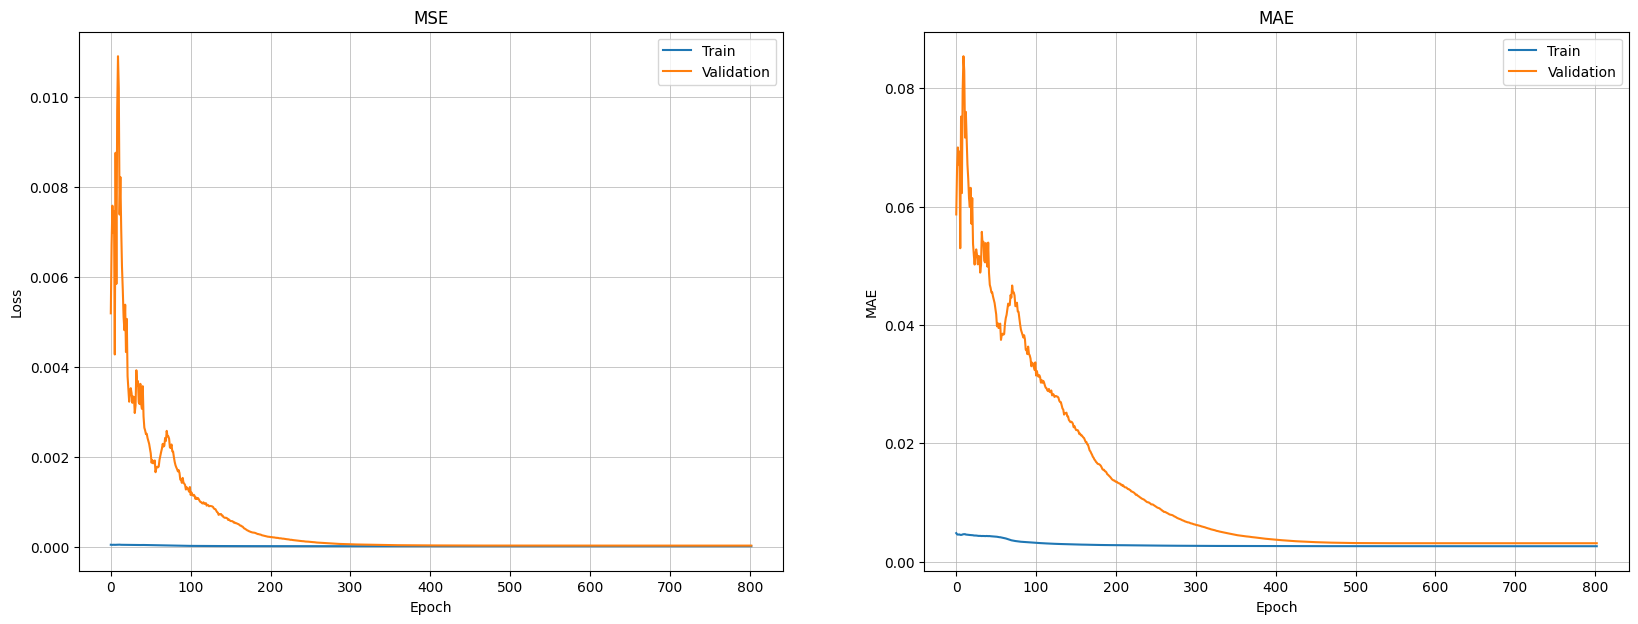

In [37]:
# Learning Curves:
plot_history(history)

# Reinterpreting the y_pred to an actual absolute BDI value

In [311]:
model.evaluate(generator_val)

351/351 [==============================] - 0s 663us/step - loss: 3.2546e-05 - mae: 0.0031


[3.254639159422368e-05, 0.003113764338195324]

In [173]:
X_test_scaled.shape[0]

1413

In [297]:
#SOLUTION

generator_baseline = TimeseriesGenerator(X_test, y_test, length=10,
                                         batch_size=X_test_scaled.shape[0], sampling_rate=1, stride=1
                                        )

In [298]:
for X, y in generator_baseline:
    X_pred_list = X
    y_true_list = y

In [299]:
X_last_list = []
for i in range(len(X_pred_list)):
    X_last_list.append(X_pred_list[i,9,:])

In [300]:
y_pred_log_diff = model.predict(X_pred_list)
y_pred_log_diff

array([[0.6598803 ],
       [0.6597918 ],
       [0.6596982 ],
       ...,
       [0.66103184],
       [0.6609924 ],
       [0.6609475 ]], dtype=float32)

In [305]:
X_last_list

[array([869.4]),
 array([853.6]),
 array([837.8]),
 array([822.]),
 array([837.6]),
 array([853.2]),
 array([868.8]),
 array([884.4]),
 array([900.]),
 array([915.4]),
 array([930.8]),
 array([946.2]),
 array([961.6]),
 array([977.]),
 array([968.2]),
 array([959.4]),
 array([950.6]),
 array([941.8]),
 array([933.]),
 array([952.8]),
 array([972.6]),
 array([992.4]),
 array([1012.2]),
 array([1032.]),
 array([1053.2]),
 array([1074.4]),
 array([1095.6]),
 array([1116.8]),
 array([1138.]),
 array([1162.4]),
 array([1186.8]),
 array([1211.2]),
 array([1235.6]),
 array([1260.]),
 array([1249.8]),
 array([1239.6]),
 array([1229.4]),
 array([1219.2]),
 array([1209.]),
 array([1203.8]),
 array([1198.6]),
 array([1193.4]),
 array([1188.2]),
 array([1183.]),
 array([1212.8]),
 array([1242.6]),
 array([1272.4]),
 array([1302.2]),
 array([1332.]),
 array([1342.6]),
 array([1353.2]),
 array([1363.8]),
 array([1374.4]),
 array([1385.]),
 array([1408.4]),
 array([1431.8]),
 array([1455.2]),
 array(

In [296]:
X_pred_list_trans = scaler_X.transform(X_pred_list)

/Users/justinrlawes/.pyenv/versions/3.8.12/envs/bdi_predict/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [301]:
y_pred_diff = 10**y_pred_log_diff

In [306]:
y_pred_dollar = y_pred_diff*X_last_list

# Learning Curves viz code:

In [285]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # Loss:MSE
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # Metrics:MAE
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [307]:
y_test_10_rem = y_test.iloc[:-10]

In [308]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE_dollar = mean_absolute_error(y_test_10_rem, y_pred_dollar)
MAE_dollar

#THIS IS VERY WRONG...

7755.885152538912

In [312]:
# TO DO: IMPLEMENT THE ABOVE HEADING LATER.